In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())


['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The most recent date in the dataset is: {most_recent_date}")


The most recent date in the dataset is: 2017-08-23


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

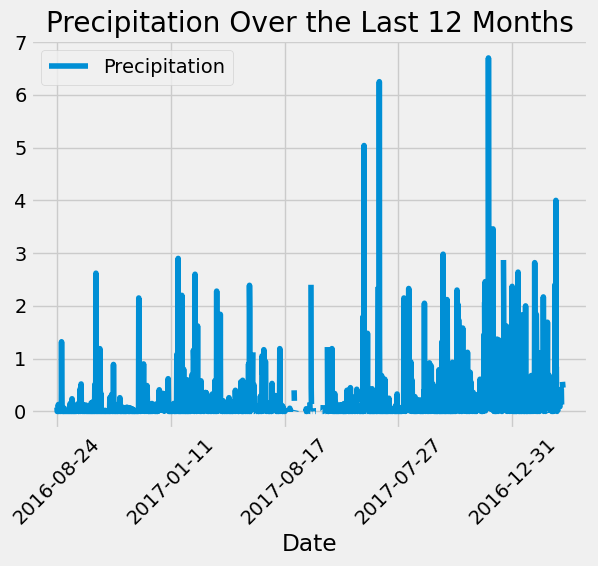

<Figure size 1200x600 with 0 Axes>

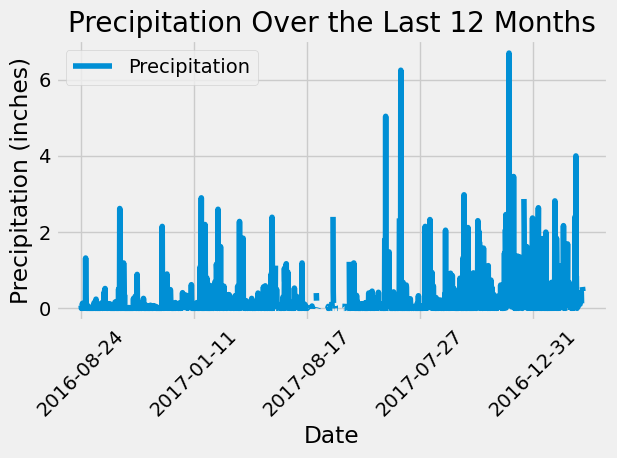

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.date <= most_recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
precipitation_df.sort_values('Date')


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12, 6))
precipitation_df.plot(x='Date', y='Precipitation', rot=45)
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.tight_layout()
plt.show()




In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = precipitation_df['Precipitation'].describe()
print("\nPrecipitation Summary Statistics:")
print(precipitation_stats)





Precipitation Summary Statistics:
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
print(f"\nTotal number of stations: {station_count}")



Total number of stations: 9


In [23]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
    
print("\nStations and their measurement counts (in descending order):")
print("Station ID\tCount")
print("--------------------")
for station, count in station_counts:
    print(f"{station}\t{count}")

        



Stations and their measurement counts (in descending order):
Station ID	Count
--------------------
USC00519281	2772
USC00519397	2724
USC00513117	2709
USC00519523	2669
USC00516128	2612
USC00514830	2202
USC00511918	1979
USC00517948	1372
USC00518838	511


In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Get the most active station id
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]
    
# Calculate the lowest, highest, and average temperature for the most active station
temp_stats = session.query(func.min(Measurement.tobs),
                           func.max(Measurement.tobs),
                           func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
    
#Unpack the results
min_temp, max_temp, avg_temp = temp_stats[0]
    
print(f"\nTemperature Statistics for Station {most_active_station}:")
print(f"Lowest Temperature: {min_temp:.1f}∘F")
print(f"Highest Temperature: {max_temp:.1f}∘F")
print(f"Average Temperature: {avg_temp:.1f}∘F")
    


Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0∘F
Highest Temperature: 85.0∘F
Average Temperature: 71.7∘F


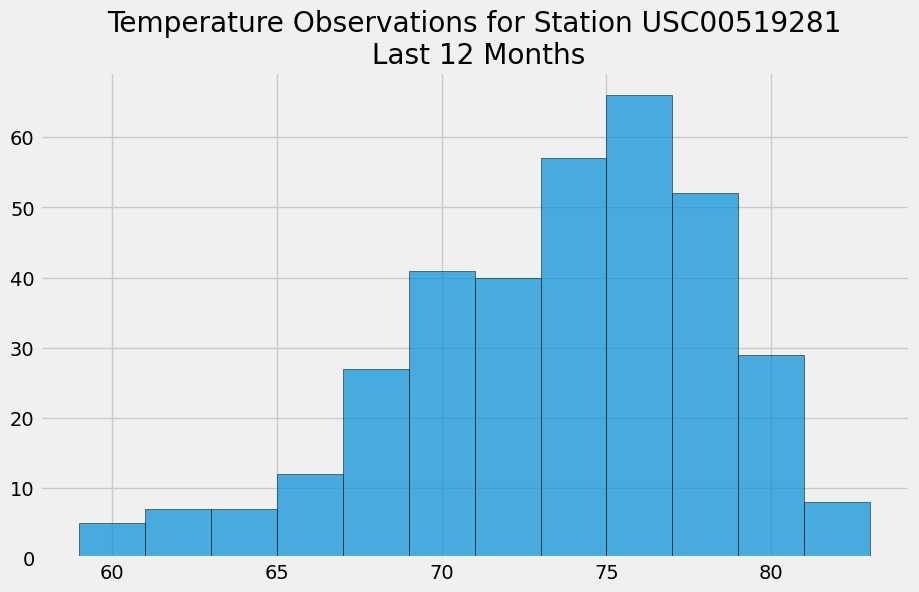

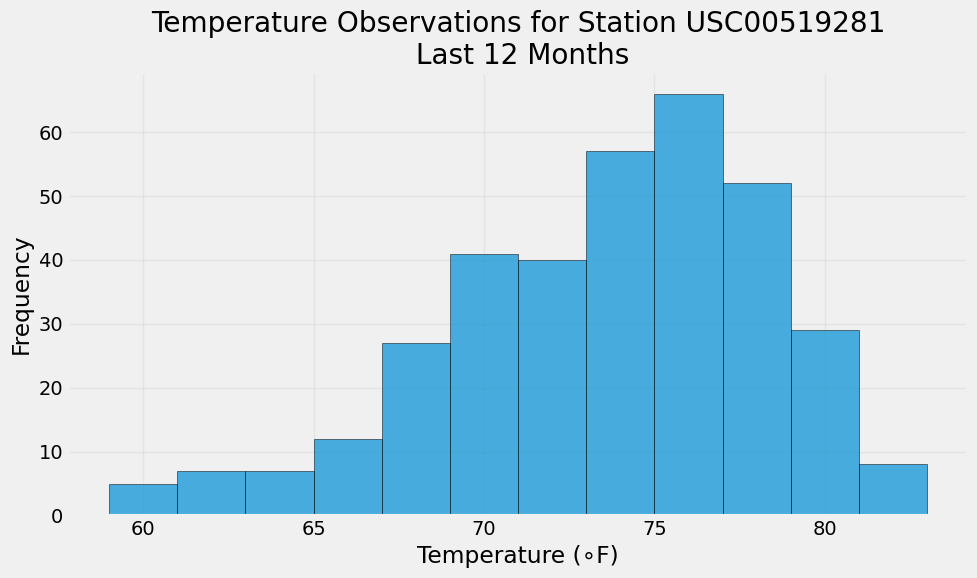

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

temp_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.date <= most_recent_date).all()
    
#Convert the results to a list of temperatures
temps = [temp[0] for temp in temp_data]

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temps, bins=12, alpha=0.7, edgecolor='black')
plt.title(f'Temperature Observations for Station {most_active_station}\n Last 12 Months')
plt.xlabel('Temperature (∘F)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



# Close Session

In [28]:
# Close Session
session.close()